In [15]:
import pandas as pd
import numpy as np
import keras
from tqdm.notebook import tqdm
from IPython.display import display
import sklearn
from matplotlib import pyplot as plt
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Flatten, Input
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

To do:

- Load alle trials i stedte for data (all_readings = np.load('all_readings.npy', allow_pickle=True))
- Ryd op i de trials.
- Generér uniform trials (3D array med [batch, samples,features])
    - Altså, cellen med #Make all trials same length - Save this cell
    - batch er alle dine træningspunkter
    - samples er dine time series (små udklip af eye tracking)
    - features er... ja, features.
- Få LSTM til at virke med din data - skidevære med metrics.
- Når det virker kan du rode rundt med ordentlig klassifikation
- Evt separer saccades og fixations?

In [9]:
target = 'gender' #'age'
even_gender = False

sample_length = 10
seed = 42

epochs=5
verbose=True
batch_size=32

np.random.seed(seed) 

In [3]:
data = np.load('all_readings.npy', allow_pickle=True)
data = [i for i in data if len(i)>sample_length]

if even_gender:
    data = data[:-52]

In [4]:
def make_trials_uniform(trials):
    uniform_X = []
    uniform_y = []
    show = True
    for trial in tqdm(trials):
        X, y = cleanup_reading(trial, show=show)
        show=False
        length = X.shape[0]
        for i in range(sample_length, length-length%sample_length, sample_length):
            uniform_X.append(X.iloc[i-sample_length:i])
            uniform_y.append(y.values[0])

    return np.array(uniform_X), np.array(uniform_y)

def experimental(trial):    
    trial = trial[trial['eventType']==0]
    trial = trial.drop('eventType', axis=1)
    trial = trial.replace(0,np.nan).dropna(axis=1,how="all")
    trial['false'] = np
    return trial[['duration','meanPupilDiameter']]

    

def cleanup_reading(trial, show=False):
    trial = trial[trial.columns[1:]]
    trial = trial[trial['eye']=='right']
    trial = trial.drop('eye',1)
    trial = trial.drop('eventIdxLeft',1)
    trial = trial.drop('eventIdxRight',1)
    trial['eventType'] = trial['eventType'].replace(['saccade'], 1)
    trial['eventType'] = trial['eventType'].replace(['fixation'], 0)
    trial = trial.fillna(0)
    
    #trial = experimental(trial)
    
    feats = trial.columns
    trial = trial.reset_index()
    
    if show:
        print("Your features")
        display(trial.head())
        
    return trial[feats[:-2]], trial[feats[-2:]]

In [5]:
np.random.shuffle(data)
X,y = make_trials_uniform(data)
X,y = sklearn.utils.shuffle(X, y, random_state=seed)
y = y-1

if target == 'gender':
    y = y[:,0] #Only tage gender
else:
    y = y[:,1]

y = y.reshape(-1, 1)
print(f'X shape: {X.shape}, y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed)

  0%|          | 0/5584 [00:00<?, ?it/s]

Your features


,index,duration,meanPupilDiameter,eventType,meanX,meanY,startSaccadeX,startSaccadeY,endSaccadeX,endSaccadeY,microsaccadeCount,microsaccadeAmplitude,microsaccadePeakVelocity,gender,age
0,10,20,0.000000,1,0.000000,0.000000,409.952,199.078,528.719,201.141,0.0,0.000000,0.000000,2.0,24.0
1,12,216,3.416491,0,531.211073,205.176436,0.000,0.000,0.000,0.000,1.0,7.146511,16.783910,2.0,24.0
2,15,24,0.000000,1,0.000000,0.000000,529.090,195.423,705.419,198.423,0.0,0.000000,0.000000,2.0,24.0
3,16,196,3.429929,0,718.079880,200.171140,0.000,0.000,0.000,0.000,1.0,4.147090,14.326414,2.0,24.0
4,18,16,0.000000,1,0.000000,0.000000,728.998,186.610,665.861,198.548,0.0,0.000000,0.000000,2.0,24.0


X shape: (14969, 10, 12), y shape: (14969, 1)


In [10]:
model = keras.Sequential()
model.add(Input(shape=(X_train[0].shape)))
model.add(BatchNormalization(input_shape = (32,1)))
model.add(LSTM(10))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, 
                         batch_size=batch_size, callbacks=[callback])

Epoch 1/5
281/281 [==============================] - 5s 19ms/step - loss: 0.6873 - accuracy: 0.5429 - val_loss: 0.6790 - val_accuracy: 0.5748
Epoch 2/5
281/281 [==============================] - 4s 16ms/step - loss: 0.6745 - accuracy: 0.5787 - val_loss: 0.6693 - val_accuracy: 0.5859
Epoch 3/5
281/281 [==============================] - 4s 16ms/step - loss: 0.6719 - accuracy: 0.5867 - val_loss: 0.6702 - val_accuracy: 0.5846
Epoch 4/5
281/281 [==============================] - 4s 14ms/step - loss: 0.6692 - accuracy: 0.5920 - val_loss: 0.6698 - val_accuracy: 0.5788
Epoch 5/5
281/281 [==============================] - 4s 13ms/step - loss: 0.6668 - accuracy: 0.5902 - val_loss: 0.6673 - val_accuracy: 0.5895


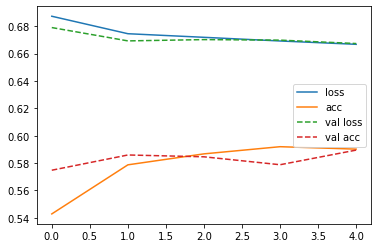

In [12]:
plt.plot(history.history['loss'], label="loss");
plt.plot(history.history['accuracy'], label="acc");
plt.plot(history.history['val_loss'], '--', label="val loss");
plt.plot(history.history['val_accuracy'], '--', label="val acc");
plt.legend();

In [13]:
y_pred= model.predict(X_test).ravel()
y_pred = (np.floor(y_pred+0.5)*2)-1
fpr, tpr, thresholds = roc_curve((y_test*2)-1, y_pred, pos_label=1)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dum_y_pred= dummy.predict(X_test).ravel()
dum_fpr, dum_tpr, dum_thresholds = roc_curve((y_test*2)-1, dum_y_pred, pos_label=1)

# rfc = RandomForestClassifier()
# rfc.fit(X_train, y_train)
# rfc_y_pred= rfc.predict(X_test).ravel()
# rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test-1, rfc_y_pred-1)

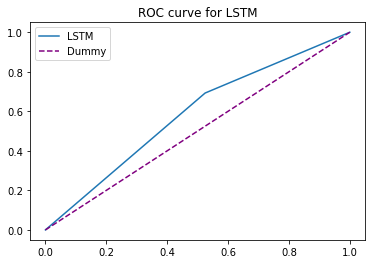

In [14]:
# fig = plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="LSTM")
plt.plot(dum_fpr,dum_tpr,'--',label="Dummy", c='purple')
plt.title("ROC curve for LSTM")
plt.legend()

In [16]:
def plot_roc_cur(fper, tper, label="", line="", title="plot title"):
    plt.plot(fper, tper, line, label=label)
    #plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", line="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, line=line, title=title) 

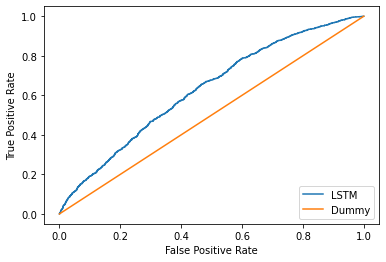

In [19]:
y_pred= model.predict(X_test).ravel()
y_pred = (np.floor(y_pred+0.5)*2)-1

create_roc_curve(model.predict(X_test), y_test, label="LSTM")
create_roc_curve(dummy.predict(X_test), y_test, label="Dummy")

In [ ]:
y_train[0], y_train[2]

In [ ]:
y_train